# Load Default pyBSM Parameters
You can use this notebook to run an example image through a series of perturbations as defined by the parameters provided to the pyBSM package. These parameters are loaded in according to what is provided in the default config.

```{seealso}
For broader context, [pyBSM documentation](https://pybsm.readthedocs.io/en/latest/explanation.html) provides foundational theory on image formation concepts.
```

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/pybsm_default_config.ipynb)

## Set Up the Environment

```{note}
We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown.
```

In [1]:
import warnings

warnings.filterwarnings("ignore")

```{important}
This notebook requires NRTK with the following extra(s):

- `pybsm`: pyBSM sensor simulation library for physics-based optical transfer function perturbations

The next cell will install these extra(s). See [Installation](<project:/getting_started/installation.rst>) for alternatives.
```

In [2]:
%pip install -qU pip
print("Installing nrtk with required extras...")
%pip install -q "nrtk[pybsm]"
print("Done!")

from nrtk.utils._extras import print_extras_status  # noqa: E402 - intentionally after %pip install

print_extras_status()

Note: you may need to restart the kernel to use updated packages.
Installing nrtk with required extras...


Note: you may need to restart the kernel to use updated packages.
Done!
Detected status of NRTK extras and their dependencies:



[albumentations]
  - nrtk-albumentations       ✗ missing

[diffusion]
  - torch                     ✗ missing
  - diffusers                 ✗ missing
  - accelerate                ✗ missing
  - Pillow                    ✓ 12.1.1
  - transformers              ✗ missing
  - protobuf                  ✗ missing

[graphics]
  - opencv-python             ✗ missing

[headless]
  - opencv-python-headless    ✗ missing

[maite]
  - maite                     ✗ missing

[pillow]
  - Pillow                    ✓ 12.1.1

[pybsm]
  - pybsm                     ✓ 0.14.3

[skimage]
  - scikit-image              ✗ missing

[tools]
  - kwcoco                    ✗ missing
  - Pillow                    ✓ 12.1.1
  - click                     ✓ 8.3.1
  - fastapi                   ✗ missing
  - uvicorn                   ✗ missing
  - pydantic                  ✗ missing
  - pydantic-settings         ✗ missing
  - python-json-logger        ✗ missing

[waterdroplet]
  - scipy                     ✓ 1.17.1
  - numba

    https://nrtk.readthedocs.io/en/stable/



```{note}
**Colab users**: After setting up the environment, you may need to "Restart Runtime" to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).
```

In [3]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from nrtk.impls.perturb_image.optical.otf import load_default_config

## Define Sensor and Scenario Parameters via Default Config

These parameters describe the sensor that was used to capture the original image and scenario we are imaging in. 

```{seealso}
See [pyBSM documentation](https://pybsm.readthedocs.io/en/latest/explanation.html#main-sensor-variables) for general information on the meaning of these parameters and [example UAV configuration](https://pybsm.readthedocs.io/en/latest/default_configs.html#Example-UAV-Configuration) for more details on how we reached the default UAV configuration.
```

In [4]:
# dirpath = os.path.dirname(os.path.abspath(__file__))
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde89c30d6f4e17c9efc/download"

img_path = os.path.join(data_dir, "M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff")

if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_file = "./data/M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff"
image = np.asarray(Image.open(img_file))

###################################################
# Load in the default Blackfly parameters
sensor_and_scenario = load_default_config(preset="blackfly")
####################################################

## Use the Perturber Multivariate Factory

Finally, we use the sensor and scenario objects to create multiple pyBSM perturbers using `PerturberMultivariateFactory`. We iterate over 7 different `ground_range` values for the sample image.

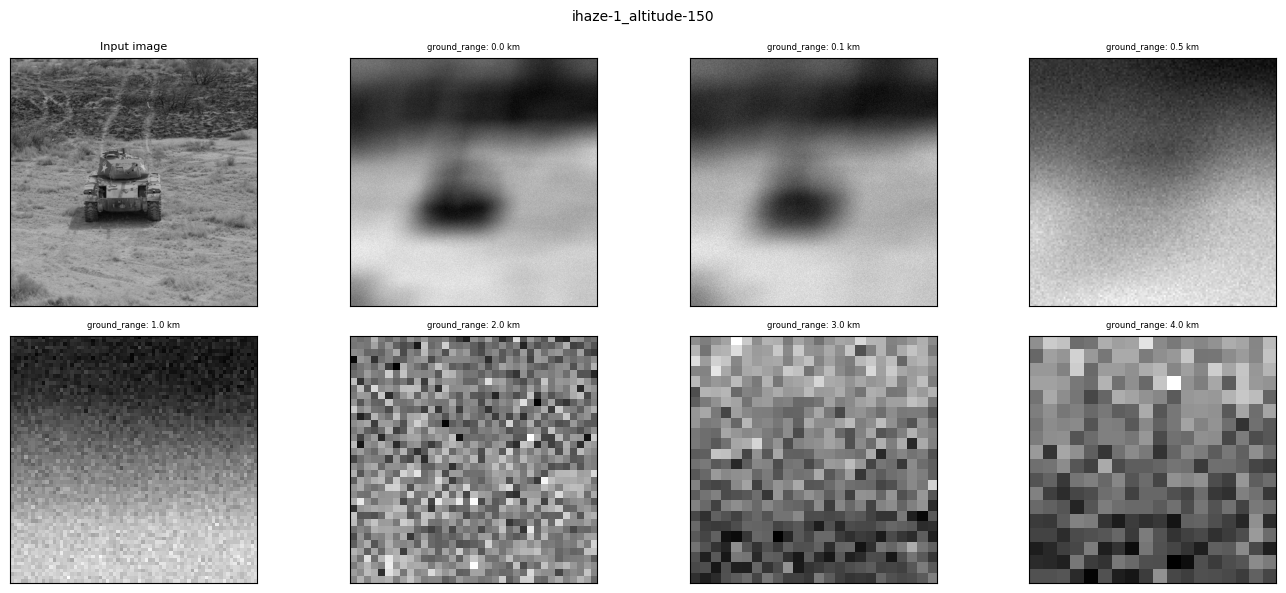

In [5]:
from nrtk.impls.perturb_image.optical import PybsmPerturber
from nrtk.impls.perturb_image_factory import PerturberMultivariateFactory

# ground_range = np.arange(0, 101e3, 10e3)
# ground_range = np.arange(0, 10, 2)
ground_range = np.array([0, 0.1e3, 0.5e3, 1e3, 2e3, 3e3, 4e3])
img_gsd = 3.19 / 160.0
perturber_factory = PerturberMultivariateFactory(
    perturber=PybsmPerturber,
    theta_keys=["ground_range"],
    thetas=[ground_range],
    perturber_kwargs=sensor_and_scenario,
)
idx = 1
fig, ax = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle(
    "ihaze-" + str(sensor_and_scenario["ihaze"]) + "_altitude-" + str(sensor_and_scenario["altitude"]),
    fontsize=10,
)
ax = ax.flatten()  # makes indexing easier
ax[0].set_title("Input image", fontdict={"fontsize": 8})
ax[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax[0].imshow(image, cmap="gray")
for ii in np.arange(0, ground_range.shape[0]):
    idx = ii + 1

    ax[idx].set_title(
        "ground_range: " + str(ground_range[ii] / 1000) + " km",
        fontdict={"fontsize": 6},
    )
    img_out, *_ = perturber_factory[ii](image=image, img_gsd=img_gsd)
    ax[idx].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    ax[idx].imshow(img_out, cmap="gray")
plt.tight_layout()
plt.show()